In [18]:
import pandas as pd
#import pylab
#import scipy
import matplotlib.pyplot as plt
import matplotlib #so I can call next line
matplotlib.style.use('ggplot')
import seaborn as sns
import numpy as np

#visuals
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format #7,123,001.34
#'{:20,.2f}'.format #change pandas display format
pd.options.display.max_rows = 20 
#pd.get_option("display.max_rows")


from __future__ import division #so I can have float as std and int as //

In [19]:
#in-memory grep implementation, filter lines starting wth filterKeyword
#return text string - memory hungry but fast
#http://stackoverflow.com/questions/10717504/is-it-possible-to-use-read-csv-to-read-only-specific-lines
def SimpleLineGrep(ASCIIfileName,filterKeyword):
  try:
    from StringIO import StringIO
  except ImportError:
    from io import StringIO
  s = StringIO()

  with open(ASCIIfileName) as f:
      for line in f:
          if line.startswith(filterKeyword):
              s.write(line)
  s.seek(0) # "rewind" to the beginning of the StringIO object

  return s

![](.\pics\GRACE_UoN.png)


# GNSS RAW ranges in Android N
## Lukasz K Bonenberg


This notebook explains how to calculate pseudo-ranges (code measurments) obtainable from the Android API 24+. This is python implementation of `ProcessGnssMeas.m` Matlab routine from [Google's GPS Measurement Tools](https://github.com/google/gps-measurement-tools).

## Loading and reading data

Android data read by GNSSLogger output (hardware depending):


* Position, Velocity and Time (PVT) solution; 
* ephemeris information;
* Accumulated Delta Range (Carrier);
* Doppler, SNR, observation uncertainty, flags;
* **HW clocks** that we can use to calculate **Pseudorange/Pseudorange Rate** (code)

For this workshop we will only focus on the last one.

![](.\pics\Terry_GPS_nav01.jpg)

## GNSS Navigation Concept

* User measures distance to four satellites
* Satellites transmit their current positions in orbit
* User solves for his position and **clock error**


### Pseudorange is:

* One-way range (distance) between satellite and receiver
* Measurement of time-of-flight of coded signals
* time difference between satellite and the receiver $$L = \frac{T_{receiver \atop arrival}
-T^{satellite \atop transmission}}{c}$$.

## Confirming validity of the data

To obtain second level TTFF smartphone GNSSe use measurements long before TOW is decoded using AGPS.  These measurements are considered invalid in traditional GNSS understanding. To confirm with the traditional approach we should only use the ranges with TOW set (1st and 3rd-bit set). For more information check GPS HAL - *gps.h*.
To demonstrate this test logic:

In [3]:
# reads GNSSLogger log file into pandas data frame using Google Logger 2.0
def readGNSSLogger (data_file):
  print("filtering PR from %s" % data_file)
  RawMeas = SimpleLineGrep(data_file,'Raw')
  # for 7.0 
  #colNames = ["Raw","ElapsedRealtimeMillis","TimeNanos","LeapSecond","TimeUncertaintyNanos","FullBiasNanos","BiasNanos","BiasUncertaintyNanos","DriftNanosPerSecond","DriftUncertaintyNanosPerSecond","HardwareClockDiscontinuityCount","Svid","TimeOffsetNanos","State","ReceivedSvTimeNanos","ReceivedSvTimeUncertaintyNanos","Cn0DbHz","PseudorangeRateMetersPerSecond","PseudorangeRateUncertaintyMetersPerSecond","AccumulatedDeltaRangeState","AccumulatedDeltaRangeMeters","AccumulatedDeltaRangeUncertaintyMeters","CarrierFrequencyHz","CarrierCycles","CarrierPhase","CarrierPhaseUncertainty","MultipathIndicator","SnrInDb","ConstellationType","AgcDb","CarrierFrequencyHz"]
  # for 8.0
  # colNames = ["Raw","ElapsedRealtimeMillis","TimeNanos","LeapSecond","TimeUncertaintyNanos","FullBiasNanos","BiasNanos","BiasUncertaintyNanos","DriftNanosPerSecond","DriftUncertaintyNanosPerSecond","HardwareClockDiscontinuityCount","Svid","TimeOffsetNanos","State","ReceivedSvTimeNanos","ReceivedSvTimeUncertaintyNanos","Cn0DbHz","PseudorangeRateMetersPerSecond","PseudorangeRateUncertaintyMetersPerSecond","AccumulatedDeltaRangeState","AccumulatedDeltaRangeMeters","AccumulatedDeltaRangeUncertaintyMeters","CarrierFrequencyHz","CarrierCycles","CarrierPhase","CarrierPhaseUncertainty","MultipathIndicator","SnrInDb","ConstellationType","AgcDb","CarrierFrequencyHz"]
  colNames = ["Raw","ElapsedRealtimeMillis","TimeNanos","LeapSecond","TimeUncertaintyNanos","FullBiasNanos","BiasNanos","BiasUncertaintyNanos","DriftNanosPerSecond","DriftUncertaintyNanosPerSecond","HardwareClockDiscontinuityCount","Svid","TimeOffsetNanos","State","ReceivedSvTimeNanos","ReceivedSvTimeUncertaintyNanos","Cn0DbHz","PseudorangeRateMetersPerSecond","PseudorangeRateUncertaintyMetersPerSecond","AccumulatedDeltaRangeState","AccumulatedDeltaRangeMeters","AccumulatedDeltaRangeUncertaintyMeters","CarrierFrequencyHz","CarrierCycles","CarrierPhase","CarrierPhaseUncertainty","MultipathIndicator","SnrInDb","ConstellationType"]  
  dataFrame = pd.read_csv(RawMeas, delimiter = ",",error_bad_lines=False,header=None,
                          usecols=range(1,len(colNames)),names= colNames,
                          encoding = 'utf-8-sig',na_values = ["NULL",""],engine ='c')
  return dataFrame

In [20]:
data_file = "./sampleData/s8_01.txt"
df_GNSS = readGNSSLogger(data_file)

df_GNSS = df_GNSS[1500:] #cut noisy start of data -> this is for my S8 data
df_GNSS.head()


filtering PR from ./sampleData/s8_01.txt


,ElapsedRealtimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,HardwareClockDiscontinuityCount,...,AccumulatedDeltaRangeState,AccumulatedDeltaRangeMeters,AccumulatedDeltaRangeUncertaintyMeters,CarrierFrequencyHz,CarrierCycles,CarrierPhase,CarrierPhaseUncertainty,MultipathIndicator,SnrInDb,ConstellationType
1500,93839103,109516000000,nan,nan,-1177163492483672228,0.00,7.00,nan,nan,0,...,4,"23,164.20","340,282,346,638,528,897,590,636,046,441,678,635...",nan,nan,nan,nan,0,nan,6
1501,93839103,109516000000,nan,nan,-1177163492483672228,0.00,7.00,nan,nan,0,...,1,"55,813.99",0.00,nan,nan,nan,nan,0,nan,6
1502,93839104,109516000000,nan,nan,-1177163492483672228,0.00,7.00,nan,nan,0,...,4,"-25,195.18","340,282,346,638,528,897,590,636,046,441,678,635...",nan,nan,nan,nan,1,nan,6
1503,93840078,110516000000,nan,nan,-1177163492483671792,0.00,6.98,nan,nan,0,...,1,"-6,514.31",0.00,nan,nan,nan,nan,0,nan,1
1504,93840079,110516000000,nan,nan,-1177163492483671792,0.00,6.98,nan,nan,0,...,1,"39,288.17",0.00,nan,nan,nan,nan,0,nan,1


In [21]:
print("""First let's demonstrate how bitwise operations work. 
        To set 1st bit(CODE_LOCK){:#010b}, to set 4th bit(TOW_DECODED){:#010b}
        To set both we need {:#010b}""".
      format(1<<0,1<<3,(1<<3) | (1<<0)))

First let's demonstrate how bitwise operations work. 
        To set 1st bit(CODE_LOCK)0b00000001, to set 4th bit(TOW_DECODED)0b00001000
        To set both we need 0b00001001


Now let's use the same principle to check the flags from the recorded data

In [6]:
state = df_GNSS.State.iloc[0]
print('\nRecorded state {0} can be wrote binary as: {0:#010b}'.format(state))
print('Allowing us to check if TOW flag set: {}'.format((state & (1 << 0))!=0 and (state & (1 << 3))!=0)) 


Recorded state 17 can be wrote binary as: 0b00010001
Allowing us to check if TOW flag set: False


## Which satellites are we looking at?
As an example of Android N API, lets explore [Android GNSS status](https://developer.android.com/reference/android/location/GnssStatus.html).

In [7]:
def BasicInfo(AndroidData):

  listOfSV = AndroidData.Svid.unique()
  listOfConstelations = AndroidData.ConstellationType.unique()
  GNSS_Constelations = {1:'GPS',2:'SBAS',3:'GLONASS',4:'QZSS',5:'BeiDou',6:'Galileo'}

  print('Observing following SVs:{}\nObserved constelations: {}'.format(
      ','.join(map(str,listOfSV)),','.join([GNSS_Constelations[s] for s in listOfConstelations])))

In [22]:
BasicInfo(df_GNSS)

Observing following SVs:2,11,22,6,12,14,24,25,29,31,32,13,16,15,5,23,17,7,8,97
Observed constelations: Galileo,GPS,GLONASS,BeiDou


Let's now extract GPS satelites only

In [23]:
df_oneConstelation = df_GNSS[df_GNSS.ConstellationType==1]
BasicInfo(df_oneConstelation)

Observing following SVs:2,6,12,14,24,25,29,31,32
Observed constelations: GPS


## Calculating pseudoranges

$$L = \frac{T_{receiver \atop arrival}
-T^{satellite \atop transmission}}{c}$$.

* receiver clock [ns] is calculated from `public long getTimeNanos()`
* received GNSS satelite time [ns]  is calculated from `public long getReceivedSvTimeNanos()`

### In more details:

* from `GnssMeasurementEvent.Callback` we are obtaining:
  * GnssClock
    *  +`getTimeNanos()` - receiver (local) clock
    * -`getFullBiasNanos()` referenced to GPS starting epoch (0000Z, January 6, 1980)
    * -`getBiasNanos()` for sub-ns accuracy
    * -`getTimeOffsetNanos()` estimated hardware related delays
  * Collection<GnssMeasurements>
    * +`getReceivedSvTimeNanos()` - satellite clock, referenced to GPS Week (TOW)
* all values in [ns]
* anything within 1ms is considered the same epoch

### Why use nanoseconds as a unit?

A traditional approach define GPS time as combination of GPS week and time of week. This is not possible with this approach as we obtain ranges before TOW is set. Hence our units are ns referenced to GPS starting epoch (0000Z, January 6, 1980). This creates a risk of memory/calculation problem - it is advisable to reduce this value (by subtracting current TOW value) before conducting more complex calculations.

In [28]:
GNSS_const = {'totalWeekSecs':7*24*3600,'lightSpeed':299792458} #constants


#start working on a single constelation, lazy hack
df_GNSS = df_oneConstelation

GPSWeek = (-df_GNSS.FullBiasNanos*1e-9/GNSS_const['totalWeekSecs']).astype('int')
print('GPS week {} '.format(GPSWeek.unique()[0]))

tRx_ns  = df_GNSS.TimeNanos+df_GNSS.TimeOffsetNanos-df_GNSS.FullBiasNanos.iloc[0]-(GPSWeek*GNSS_const['totalWeekSecs']*1e9)    
PR_m = (tRx_ns-df_GNSS.ReceivedSvTimeNanos)*GNSS_const['lightSpeed']*1e-9
PR_m.tail()

GPS week 1946 


6959   22,677,124.15
6960   20,512,645.39
6961   21,895,417.12
6962   23,598,963.18
6963   22,756,438.75
dtype: float64

### Putting measurments into epochs

Values calculated has to be presented per SV per epoch. We need to:

* calculate each epoch (anything within 1ms is considered the same epoch)
	* compute full cycle time of measurement, in milliseconds (see `ReadGnssLogger.m`)
* obtain SV range for each epoch per satellite


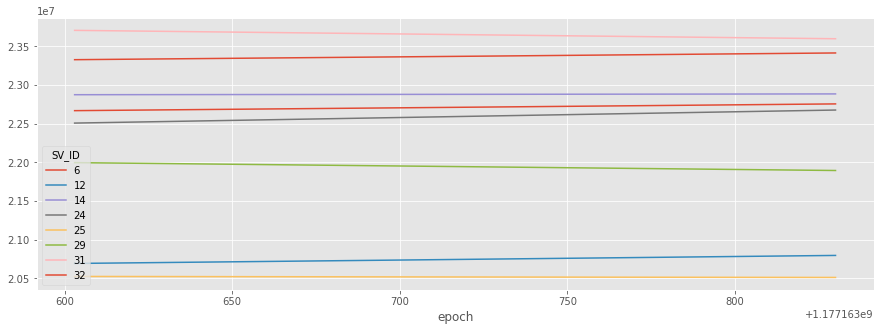

In [38]:
listOfSV = df_GNSS.Svid.unique()
allRxSec = (df_GNSS.TimeNanos - df_GNSS.FullBiasNanos)*1e-9;
epoch=allRxSec[0::len(listOfSV)]

df_PR =pd.DataFrame({'epoch': allRxSec,'SV_ID': df_GNSS.Svid,'PR': PR_m})
df_PR =df_PR[df_PR.SV_ID !=2] #remove this SV
SV_ranges = df_PR.pivot(index='epoch',columns='SV_ID', values='PR')
SV_ranges.plot(figsize=[15,5]);

## Putting it all together

Lets now define all of above as a single function.

In [13]:
def CalculatePseudorange(dataFrame):

  GNSS_const = {'totalWeekSecs':7*24*3600,'lightSpeed':299792458} #constants
  GPSWeek = (-dataFrame.FullBiasNanos*1e-9/GNSS_const['totalWeekSecs']).astype('int')
  print('GPS week {} '.format(GPSWeek.unique()))

  tRx_ns  = dataFrame.TimeNanos+dataFrame.TimeOffsetNanos-dataFrame.FullBiasNanos.iloc[0]-(GPSWeek*GNSS_const['totalWeekSecs']*1e9)   
  #tRx_ns  = dataFrame.TimeNanos-dataFrame.FullBiasNanos-(GPSWeek*GNSS_const['totalWeekSecs']*1e9)  +dataFrame.TimeOffsetNanos 
  PR_m = (tRx_ns-dataFrame.ReceivedSvTimeNanos)*GNSS_const['lightSpeed']*1e-9
  PR_m.tail()

  # get epochs
  listOfSV = dataFrame.Svid.unique()
  allRxSec = (dataFrame.TimeNanos - dataFrame.FullBiasNanos)*1e-9;
  epoch=allRxSec[0::len(listOfSV)] #all epochs, how many obs in data file

  #create temp dataframe with ranges only
  df_PR =pd.DataFrame({'epoch': allRxSec,'SV_ID': dataFrame.Svid,'PR': PR_m})
  # split by columns
  df_PRbySV = df_PR.pivot(index='epoch',columns='SV_ID', values='PR')

  return df_PRbySV


In [14]:
df_GNSS = readGNSSLogger(data_file)
df_GNSS = df_GNSS[2000:]
df_GNSS = df_GNSS[df_GNSS.ConstellationType==1]
BasicInfo(df_GNSS)

pseudoranges = CalculatePseudorange(df_GNSS)
pseudoranges.tail()


filtering PR from ./sampleData/s8_01.txt
Observing following SVs:2,6,12,14,24,25,29,31,32
Observed constelations: GPS
GPS week [1946] 


SV_ID,2,6,12,14,24,25,29,31,32
epoch,,,,,,,,,
"1,177,163,826.00","22,513,130.78","23,410,777.76","20,792,690.22","22,882,630.38","22,671,363.94","20,510,068.08","21,894,402.02","23,598,086.88","22,752,094.75"
"1,177,163,827.00","22,513,076.82","23,411,173.18","20,793,118.62","22,882,693.04","22,672,115.82","20,510,027.30","21,893,962.23","23,597,614.71","22,752,494.68"
"1,177,163,828.00","22,513,035.45","23,411,570.11","20,793,578.21","22,882,746.40","22,672,861.40","20,509,973.34","21,893,519.13","23,597,145.54","22,752,917.68"
"1,177,163,829.00","22,513,002.17","23,411,968.53","20,794,060.57","22,882,803.66","22,673,599.79","20,509,925.97","21,893,106.02","23,596,674.56","22,753,285.23"
"1,177,163,830.00","22,512,963.80","23,412,368.15","20,794,531.85","22,882,870.82","22,674,361.27","20,509,882.50","21,892,654.23","23,596,200.29","22,753,675.86"


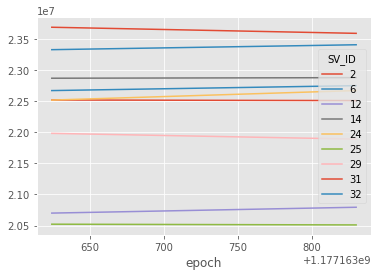

In [15]:
pseudoranges.plot();

## Time accuracy

* `getBiasUncertaintyNanos()` for the clock's Bias Uncertainty (1-Sigma) in nanoseconds. Usualy 20ns if fix, or ~$2^{e-9}$ns (2s) before.
* `getTimeUncertaintyNanos()` for the hardware clock's time Uncertainty (1-Sigma) in nanoseconds. This tends to be 0.


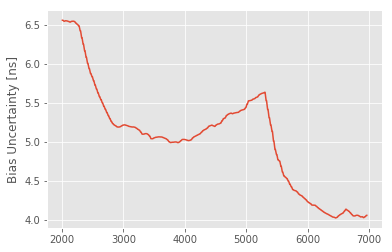

In [16]:
df_GNSS.BiasUncertaintyNanos.plot()
plt.ylabel('Bias Uncertainty [ns]');


## Problems with the accuracy of calculations

Pandas will automaticaly determine best type of variables to use. As discussed before with large numbers we might still end up with calculation errors due to rounding (float point calculation). Example below demonstrate the problem.


In [42]:
print(df_GNSS.dtypes)

ElapsedRealtimeMillis                       int64
TimeNanos                                   int64
LeapSecond                                float64
TimeUncertaintyNanos                      float64
FullBiasNanos                               int64
BiasNanos                                 float64
BiasUncertaintyNanos                      float64
DriftNanosPerSecond                       float64
DriftUncertaintyNanosPerSecond            float64
HardwareClockDiscontinuityCount             int64
                                           ...   
AccumulatedDeltaRangeState                  int64
AccumulatedDeltaRangeMeters               float64
AccumulatedDeltaRangeUncertaintyMeters    float64
CarrierFrequencyHz                        float64
CarrierCycles                             float64
CarrierPhase                              float64
CarrierPhaseUncertainty                   float64
MultipathIndicator                          int64
SnrInDb                                   float64


In [44]:
def CheckCalculus(number):

  y=number-1
  z=number-1+1
  print('Checking for floating poing overflow, it should be 1 and 0\nx-y={:}\nz-x={:}'.format(number-y,number-z))

In [50]:
x=-1151285108458178048
CheckCalculus(x)
CheckCalculus(x*100000)

CheckCalculus(x*1e3) #hidden cast to float
CheckCalculus(x*1.0) #float


#import decimal as dec


Checking for floating poing overflow, it should be 1 and 0
x-y=1
z-x=0
Checking for floating poing overflow, it should be 1 and 0
x-y=1
z-x=0
Checking for floating poing overflow, it should be 1 and 0
x-y=0.0
z-x=0.0
Checking for floating poing overflow, it should be 1 and 0
x-y=0.0
z-x=0.0


A careful approach is needed to avoid this calculation problem. Also check those additional resources:

* <http://mpmath.org/>

# Some helpful links

* [Google code](https://github.com/google/gps-measurement-tools) - this is the official code from Google, in Matlab.
* [my version of GPS Measurement tools](https://github.com/DfAC/gps-measurement-tools), mostly added notes and small changes simplifying the use of script.
* [this repo](https://github.com/DfAC/AndroidGNSS)


* [useful comments on pandas](d:\tmp\Dropbox\Edu\ION_GNSS\AndroidGNSS\)
* [bitwise operations in python](https://wiki.python.org/moin/BitwiseOperators)
* [format string](https://docs.python.org/3/library/string.html)
* [format output](https://pyformat.info)
* [Rokybun blog](http://rokubun.cat/2016/06/30/android-n-preview-gnss-measurements/)
* [BlackDotGNSS blog](http://www.blackdotgnss.com/2016/09/20/ppp-with-smartphones-are-we-there-yet/)
